This notebook will explore how NYC gets clustered based on the recyling habits and socio economic features. We will give the big data set which contains recyling habits, waste generation habits, socio-economic features and infrastrucutre of NYC. K-means clustering is an unsupervised method which means that based on these data points only the algorithm will select community districts that have similar relation ships betweeen variables and put them in a cluster. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_blobs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from scipy.signal import find_peaks


In this notebook we will analyze the clusters that form within NYC. We start with loading the data and recognizing which columns are numerical and which are categorical. This is important because if there are any numeric columns for which values are missing, we must replace it with a mean value so that the K-means clustering can operate. 

In [39]:
df=data_demo=pd.read_csv("datas/DemographicsTable.csv")

# Check for missing values in the dataframe
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print out the columns to verify
print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Impute missing values in numerical columns using the mode (most frequent value)
imputer_numeric = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])

Numeric columns: Index(['Organic Tons', 'MGP tons', 'Paper Tons', 'Refuse Tons',
       'Diversion rate (%)', 'Total Population', 'Median Age',
       'Population/acre', 'Hispanic', 'White non-Hispanic',
       'Black non-hispanic', 'Asian non-hispanic', 'Others non-hispanic',
       'Non-hispanic of 2 or more races', 'Family household(%)',
       'Non-family household (%)', 'Housing units',
       'Median household income (dollars)', 'Mean household income (dollars)',
       'Paper bins', 'MGP bins', 'Capture rates paper (2019)',
       'Capture rates MGP (2019)', 'Capture rates total (2019)',
       'Number of Commercial/Office buildings',
       'Number of Industrial/Manufacturing buildings',
       'Number of Recreation/Outdoors', 'Organic Tons per person',
       'Paper Tons per person', 'Refuse Tons per person',
       'MGP Tons per person', 'Paper bins per person', 'MGP bins per person'],
      dtype='object')
Categorical columns: Index(['District'], dtype='object')


Now we must standardize the data. This is crucial because K-means uses Euclidean distance to measure similarity between points. Without scaling, features with larger numerical ranges will dominate the distance calculations. For example, income (measured in thousands of dollars) would overwhelm variables like number of bins per person or even diversion rate which is measured in percentage. Standard scaling gives all features equal opportunity to influence the clustering.

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Diversion rate (%)', 'Capture rates paper (2019)', 'Capture rates MGP (2019)', 
                                     'Organic Tons per person', 'Paper Tons per person', 'MGP Tons per person', 
                                     'Refuse Tons per person', 'Median household income (dollars)', 
                                     'Total Population', 'Population/acre', 'Number of Commercial/Office buildings', 
                                     'Number of Industrial/Manufacturing buildings',"White non-Hispanic","Paper bins per person","MGP bins per person"]])



We will use the elbow method to find the optimal number of clusters. The elbow method plots the relationship between the number of clusters (k) and the within-cluster sum of squares (WCSS) or inertia (a measure of how tightly grouped the data points are within clusters). This is based on the euclidean distance between values within cluster and outside. As k increases, WCSS naturally decreases because points are closer to their assigned centroids, but the rate of improvement slows down after reaching the "optimal" number of clusters.

The optimal point represents the point of diminishing returns, where adding more clusters produces less significant improvements in explaining the data's variance. This creates an optimal trade-off between model complexity (number of clusters) and explanatory power.

Numeric columns: Index(['Organic Tons', 'MGP tons', 'Paper Tons', 'Refuse Tons',
       'Diversion rate (%)', 'Total Population', 'Median Age',
       'Population/acre', 'Hispanic', 'White non-Hispanic',
       'Black non-hispanic', 'Asian non-hispanic', 'Others non-hispanic',
       'Non-hispanic of 2 or more races', 'Family household(%)',
       'Non-family household (%)', 'Housing units',
       'Median household income (dollars)', 'Mean household income (dollars)',
       'Paper bins', 'MGP bins', 'Capture rates paper (2019)',
       'Capture rates MGP (2019)', 'Capture rates total (2019)',
       'Number of Commercial/Office buildings',
       'Number of Industrial/Manufacturing buildings',
       'Number of Recreation/Outdoors', 'Organic Tons per person',
       'Paper Tons per person', 'Refuse Tons per person',
       'MGP Tons per person', 'Paper bins per person', 'MGP bins per person'],
      dtype='object')
Categorical columns: Index(['District'], dtype='object')


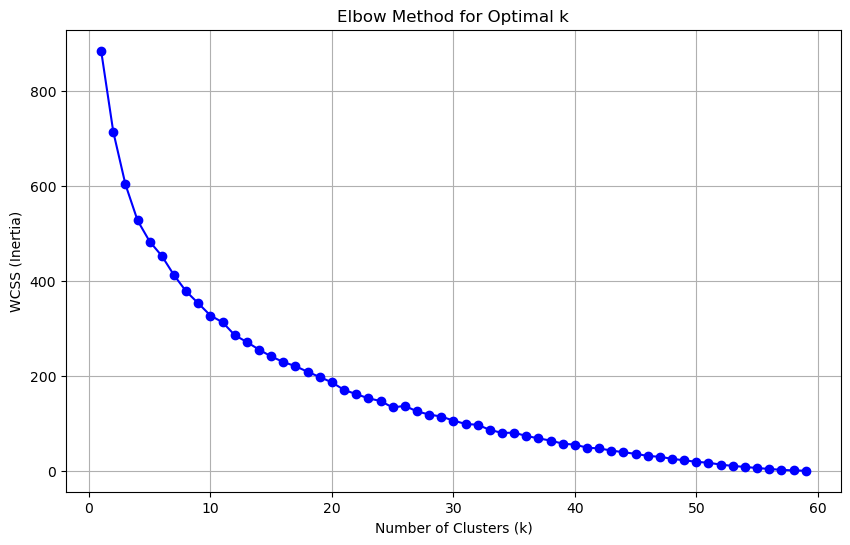

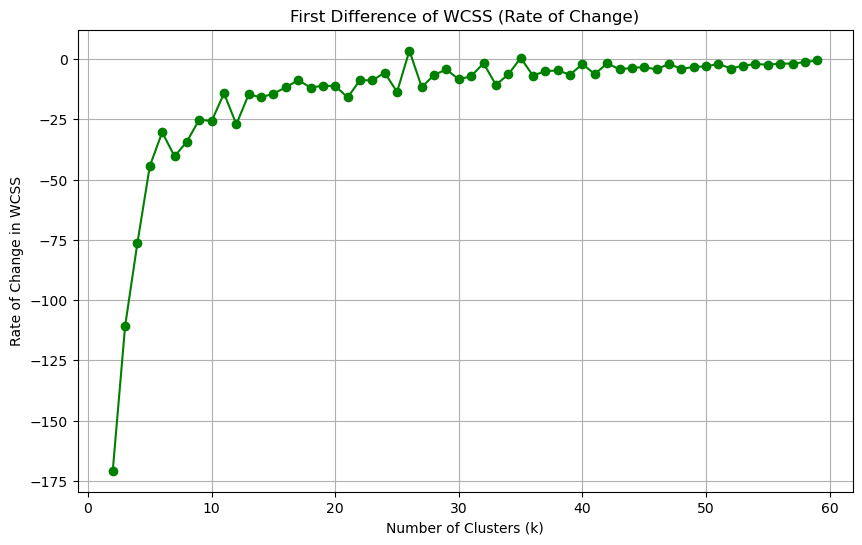

Suggested optimal number of clusters (k) based on largest drop: 7
Optimal number of clusters is: 7


In [6]:
# Function to calculate the first difference (rate of change of inertia)
def calculate_first_diff(wcss):
    return np.diff(wcss)

# Function to apply KMeans and plot the Elbow
def elbow_method(X, max_k=10):
    wcss = []

    # Fit KMeans for different k values and compute WCSS (inertia)
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Calculate the first difference (rate of change in WCSS)
    first_diff = calculate_first_diff(wcss)
    
    # Plot the Elbow Method graph (WCSS vs. number of clusters)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-', color='b', label='WCSS (Inertia)')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.grid(True)
    plt.show()

    # Plot the first difference to visualize where the largest drop happens
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_k + 1), first_diff, marker='o', linestyle='-', color='g', label='First Difference')
    plt.title('First Difference of WCSS (Rate of Change)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Rate of Change in WCSS')
    plt.grid(True)
    plt.show()

    # Use find_peaks to detect local minima (largest drop in inertia)
    peaks, _ = find_peaks(-first_diff)  # find the "valleys" in the first difference
    if len(peaks) > 0:
        # Find the first local minima (large drop in inertia)
        elbow_point = peaks[0] + 2  # adding 2 because peaks starts at k=2
    else:
        elbow_point = np.argmin(first_diff) + 2  # Fallback to minimizing the first difference directly

    print(f"Optimal number of clusters (k) based on largest drop: {elbow_point}")
    
    return elbow_point, wcss

X=df_scaled

optimal_k, wcss = elbow_method(X, max_k=59)

print(f"Optimal number of clusters is: {optimal_k}")

In [40]:
X=df_scaled
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=500, n_init=10, random_state=0)
kmeans.fit(df_scaled)  # Fit on scaled data

# Assign cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_

Now that the clusters have been assigned lets see how some variable do within that cluster. We will plot box plots of variables. Note that if the stadnard deviation is large, the clustering is not capturing that variable well. The smalled the standard deviation the better the clustering. 

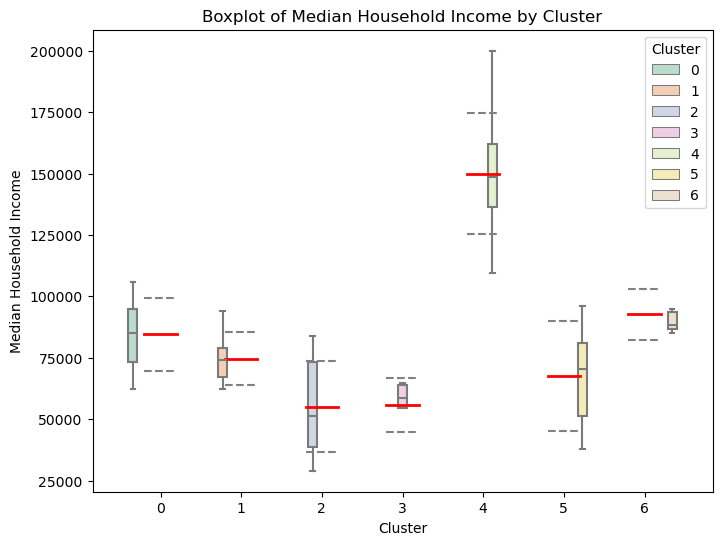

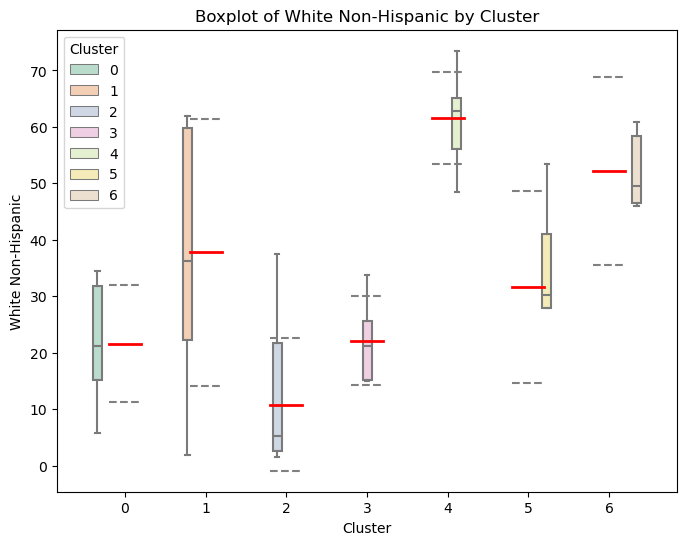

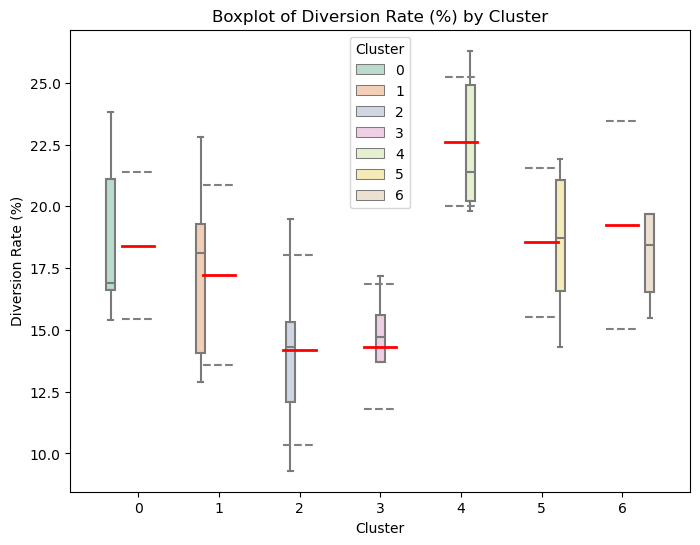

In [44]:
def plot_boxplot_with_stats(df, feature, feature_name):
    plt.figure(figsize=(8, 6))

    # Create the boxplot
    sns.boxplot(x='Cluster', y=feature, data=df, hue='Cluster', palette='Pastel2', showfliers=False)

    # Overlay means and standard deviation (optional)
    cluster_stats = df.groupby('Cluster')[feature].agg(['mean', 'std'])
    for cluster in cluster_stats.index:
        mean = cluster_stats.loc[cluster, 'mean']
        std = cluster_stats.loc[cluster, 'std']

        # Plot the mean line (red)
        plt.plot([cluster-0.2, cluster+0.2], [mean, mean], color='red', lw=2, label=f'Mean (Cluster {cluster})')

        # Plot the standard deviation lines (dashed gray)
        plt.plot([cluster-0.2, cluster+0.2], [mean-std, mean-std], color='gray', linestyle='--', label=f'Std Dev (Cluster {cluster})')
        plt.plot([cluster-0.2, cluster+0.2], [mean+std, mean+std], color='gray', linestyle='--')

    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.title(f'Boxplot of {feature_name} by Cluster')
    plt.savefig(f"Boxplot of {feature_name} by cluster.png")

    # Show the plot with legend
    #plt.legend()
    plt.show()

# Box plot for 'Median household income (dollars)'
plot_boxplot_with_stats(df, 'Median household income (dollars)', 'Median Household Income')

# Box plot for 'White non-Hispanic'
plot_boxplot_with_stats(df, 'White non-Hispanic', 'White Non-Hispanic')

# Box plot for 'Diversion rate (%)'
plot_boxplot_with_stats(df, 'Diversion rate (%)', 'Diversion Rate (%)')

We can visualize how these clusters show up on the map of NYC. This allows us to recognize how income plays a role in clustering. Below is the map based on the 7 clusters and then the map for income. 

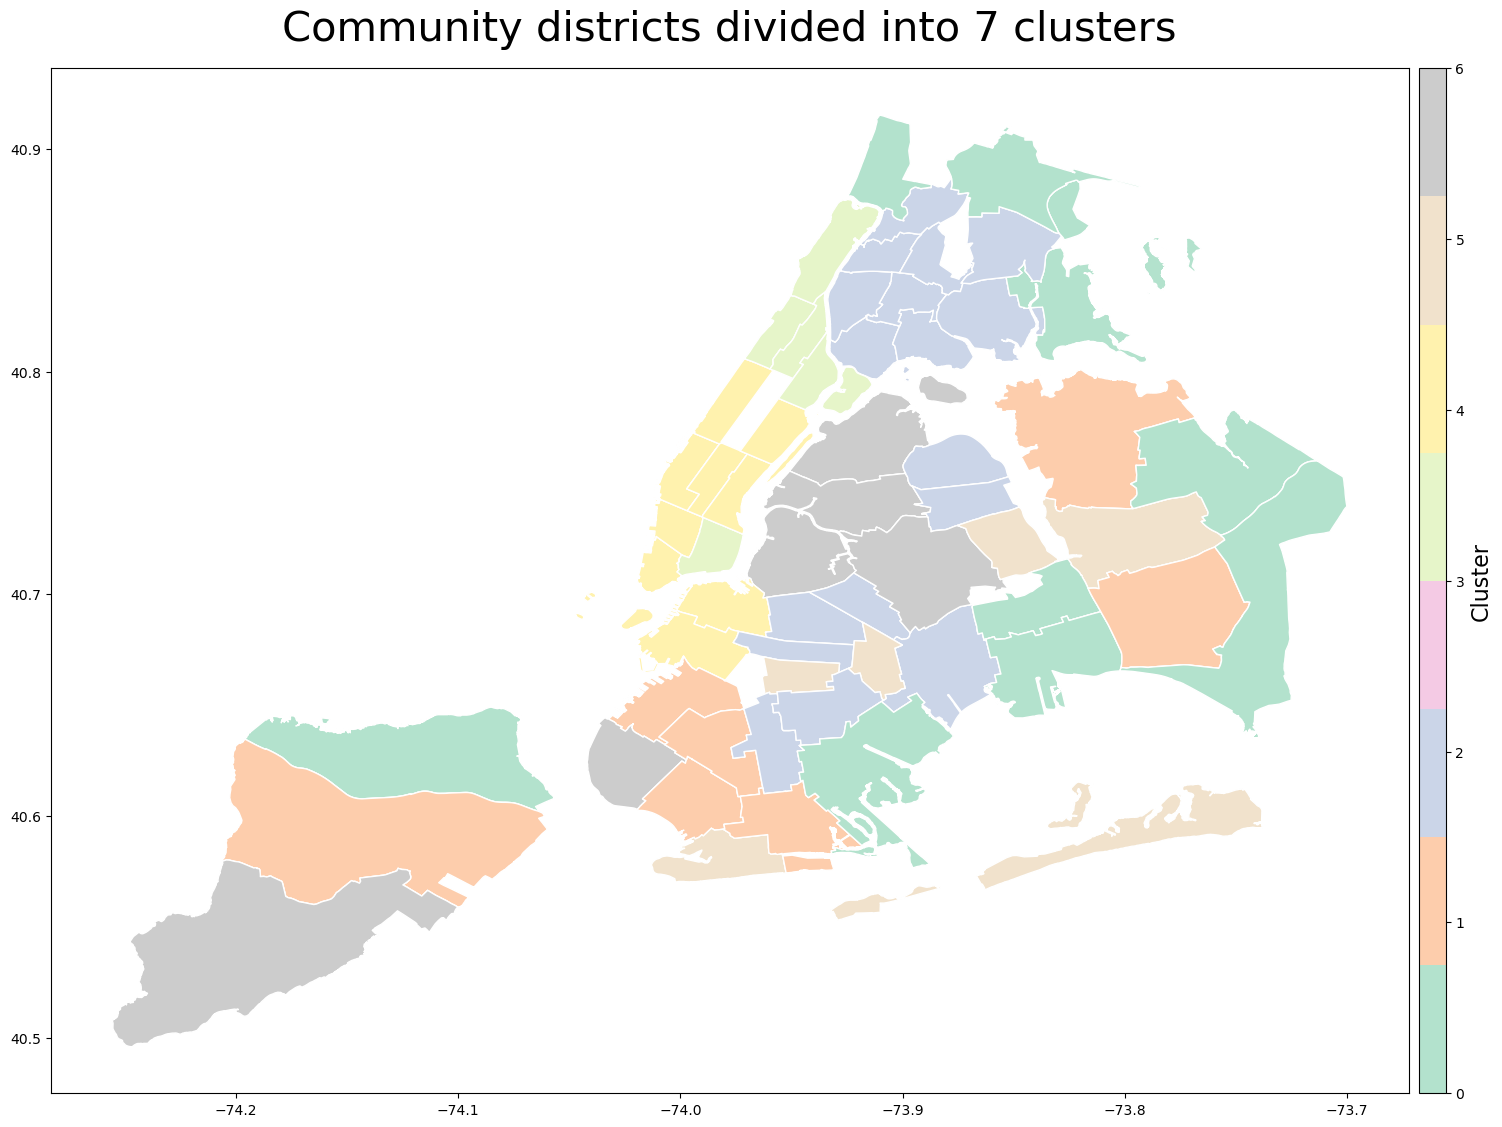

In [43]:
gdf = gpd.read_file("datas/NYC_Community_District_Tabulation_Areas_2020_769164889669816788.geojson")

df["District"] = df["District"].astype(str)
gdf["CDTA2020"] = gdf["CDTA2020"].astype(str)
merged_df = df.merge(gdf, left_on="District", right_on="CDTA2020", how="left")
merged_gdf = gpd.GeoDataFrame(merged_df, geometry="geometry")

# Create figure with portrait dimensions
fig, ax = plt.subplots(figsize=(18, 26))

# Plot the map without the legend first and get the mappable object for the colorbar
mappable = merged_gdf.plot(
    column="Cluster", 
    cmap="Pastel2", 
    legend=False,  # No legend initially
    edgecolor="white",
    ax=ax
)

# To get the mappable object (the one with the colormap)
# Find the collections that were created by the plot
mappable = ax.get_children()[0]  # This should be the PathCollection with the colormap

# Keep the map's natural aspect ratio
ax.set_aspect('equal')

# Create a divider for the existing axes to place colorbar
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 2% width of the main axes
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create colorbar in the appended axes
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Cluster", size=16)

# Add title with padding
ax.set_title("Community districts divided into 7 clusters", fontsize=30, pad=20)

# Save with tight bbox
plt.savefig("nyc_clustered.png", dpi=300, bbox_inches='tight')
plt.show()

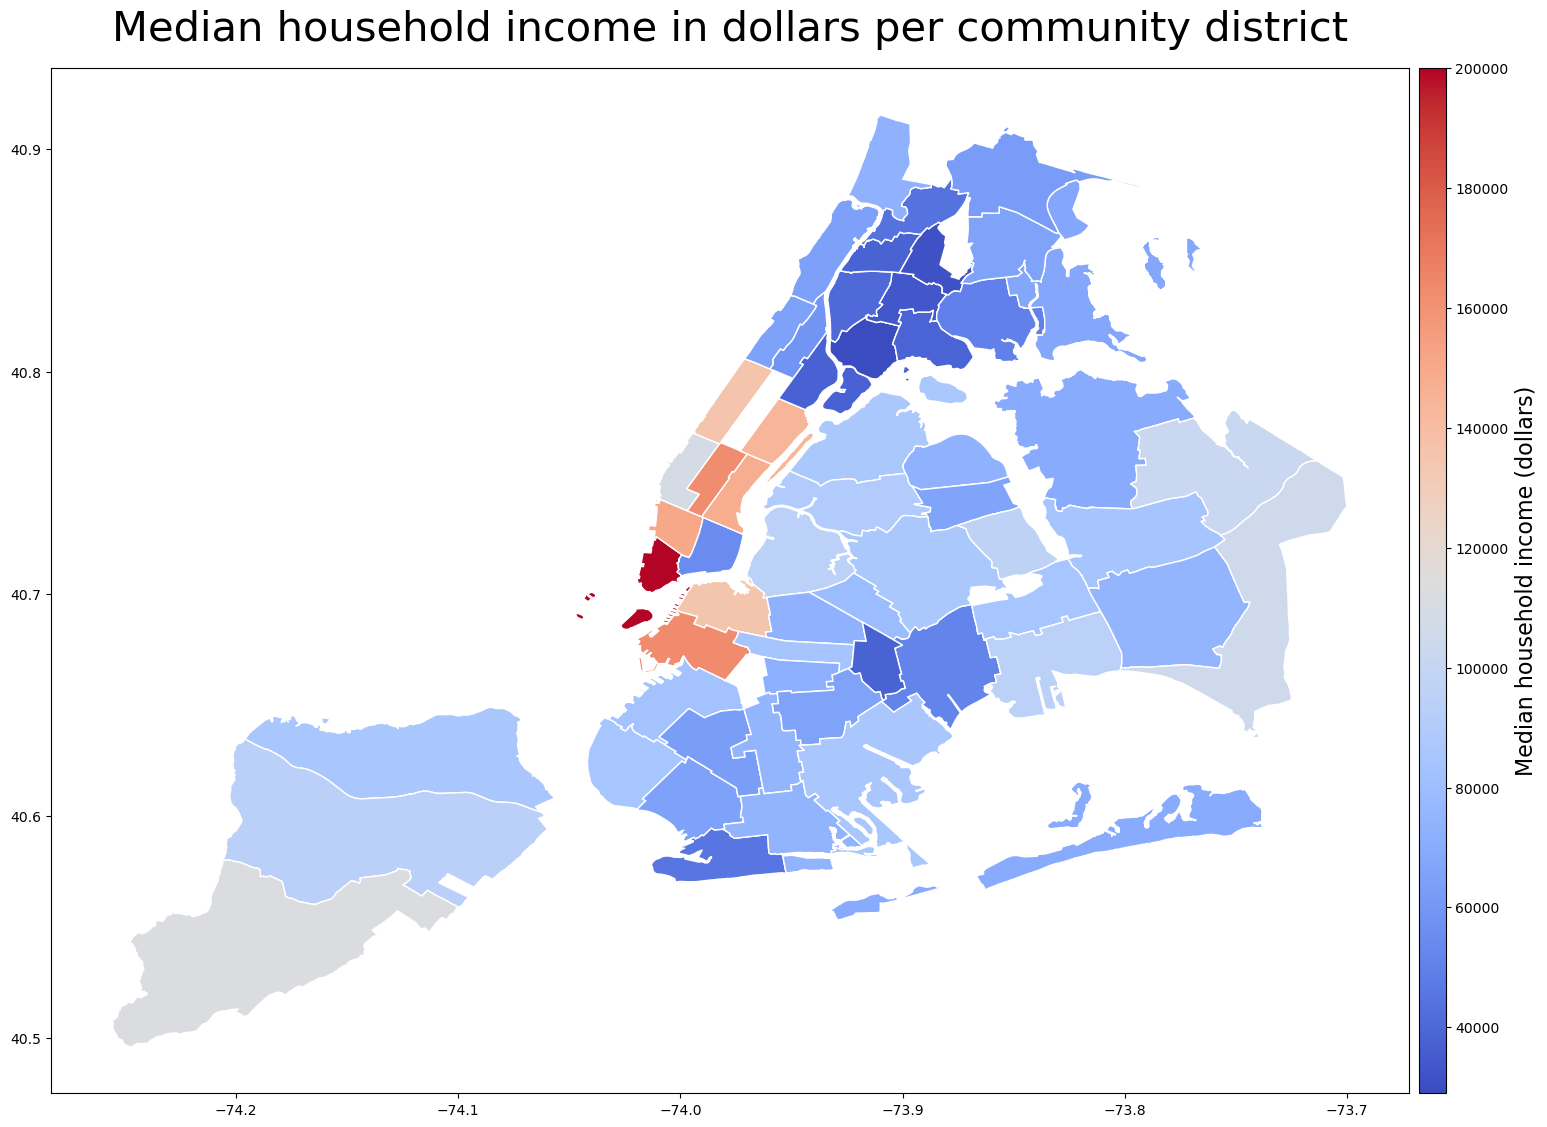

In [38]:
fig, ax = plt.subplots(figsize=(18, 26))

# Plot the map without the legend first and get the mappable object for the colorbar
mappable = merged_gdf.plot(
    column="Median household income (dollars)", 
    cmap="coolwarm", 
    legend=False,  # No legend initially
    edgecolor="white",
    ax=ax
)

# To get the mappable object (the one with the colormap)
# Find the collections that were created by the plot
mappable = ax.get_children()[0]  # This should be the PathCollection with the colormap

# Keep the map's natural aspect ratio
ax.set_aspect('equal')

# Create a divider for the existing axes to place colorbar
divider = make_axes_locatable(ax)

# Append axes to the right of the main axes, with 2% width of the main axes
cax = divider.append_axes("right", size="2%", pad=0.1)

# Create colorbar in the appended axes
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("Median household income (dollars)", size=16)

# Add title with padding
ax.set_title("Median household income in dollars per community district", fontsize=30, pad=20)

# Save with tight bbox
plt.show()